In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ML模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# 深度學習相關
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling1D, Flatten, Dense, Dropout

# 前處理

In [2]:
# 路徑
base_path = "./DRIAMS-A"
merged_file_path = os.path.join(base_path, "processed_data_A.csv")

if os.path.exists(merged_file_path):
    print("找到已合併的檔案，直接讀取...")
    df = pd.read_csv(merged_file_path)
    print(f"Data shape: {df.shape}")
else:
    # 讀取CSV檔案
    csv_path = os.path.join(base_path, "id", "2018", "2018_clean.csv")
    df_id = pd.read_csv(csv_path)

    spectra_path = os.path.join(base_path, "binned_6000", "2018")
    spectra_dict = {}
    
    for index, row in df_id.iterrows():
        code = row['code']
        spectrum_file = os.path.join(spectra_path, f"{code}.txt")
        
        if os.path.exists(spectrum_file):
            spectrum_data = pd.read_csv(spectrum_file, sep=' ')
            spectra_dict[code] = spectrum_data['binned_intensity'].values
            
    spectra_df = pd.DataFrame.from_dict(spectra_dict, orient='index')
    df = pd.merge(df_id, spectra_df, left_on='code', right_index=True)
    df.to_csv(merged_file_path, index=False)

找到已合併的檔案，直接讀取...
Data shape: (30069, 6087)


In [3]:
# 資料預處理
bacteria_mapping = {
    'Escherichia coli': 0,
    'Enterococcus faecalis': 0,
    'Klebsiella pneumoniae': 0,
    'Pseudomonas aeruginosa': 0,
    'Staphylococcus aureus': 1
}

df_filtered = df[df['species'].isin(bacteria_mapping.keys())].copy()
df_filtered['label'] = df_filtered['species'].map(bacteria_mapping)

print("\n各類別數量分布:")
print(df_filtered['species'].value_counts())
print("\n二元分類標籤分布:")
print(df_filtered['label'].value_counts())


各類別數量分布:
species
Staphylococcus aureus     2191
Escherichia coli          1970
Pseudomonas aeruginosa    1463
Enterococcus faecalis     1336
Klebsiella pneumoniae     1099
Name: count, dtype: int64

二元分類標籤分布:
label
0    5868
1    2191
Name: count, dtype: int64


In [4]:
def mRMR(X, y, k=100):
    """執行mRMR特徵選擇"""
    # 計算互信息
    MI_y = mutual_info_classif(X, y)
    
    # 初始化
    selected = []
    remaining = list(range(X.shape[1]))
    
    # 選擇第一個特徵 (最大的MI)
    first = np.argmax(MI_y)
    selected.append(first)
    remaining.remove(first)
    
    # 計算特徵間的相關係數矩陣
    corr = np.corrcoef(X.T)
    
    # 選擇剩餘的特徵
    for _ in range(k-1):
        scores = []
        for i in remaining:
            relevance = MI_y[i]
            redundancy = np.mean([abs(corr[i, j]) for j in selected])
            scores.append(relevance - redundancy)
        
        next_feature = remaining[np.argmax(scores)]
        selected.append(next_feature)
        remaining.remove(next_feature)
    
    return sorted(selected)

# 執行特徵選擇
spectrum_columns = [col for col in df_filtered.columns if col.isdigit()]
X = df_filtered[spectrum_columns]
y = df_filtered['label']

n_features = 100
selected_features = mRMR(X.values, y, k=n_features)
selected_indices = [int(spectrum_columns[i]) for i in selected_features]
X_selected = X.iloc[:, selected_features]

# 合併特徵
metadata_columns = ['code', 'species', 'label']
final_selected_df = pd.concat([df_filtered[metadata_columns], X_selected], axis=1)

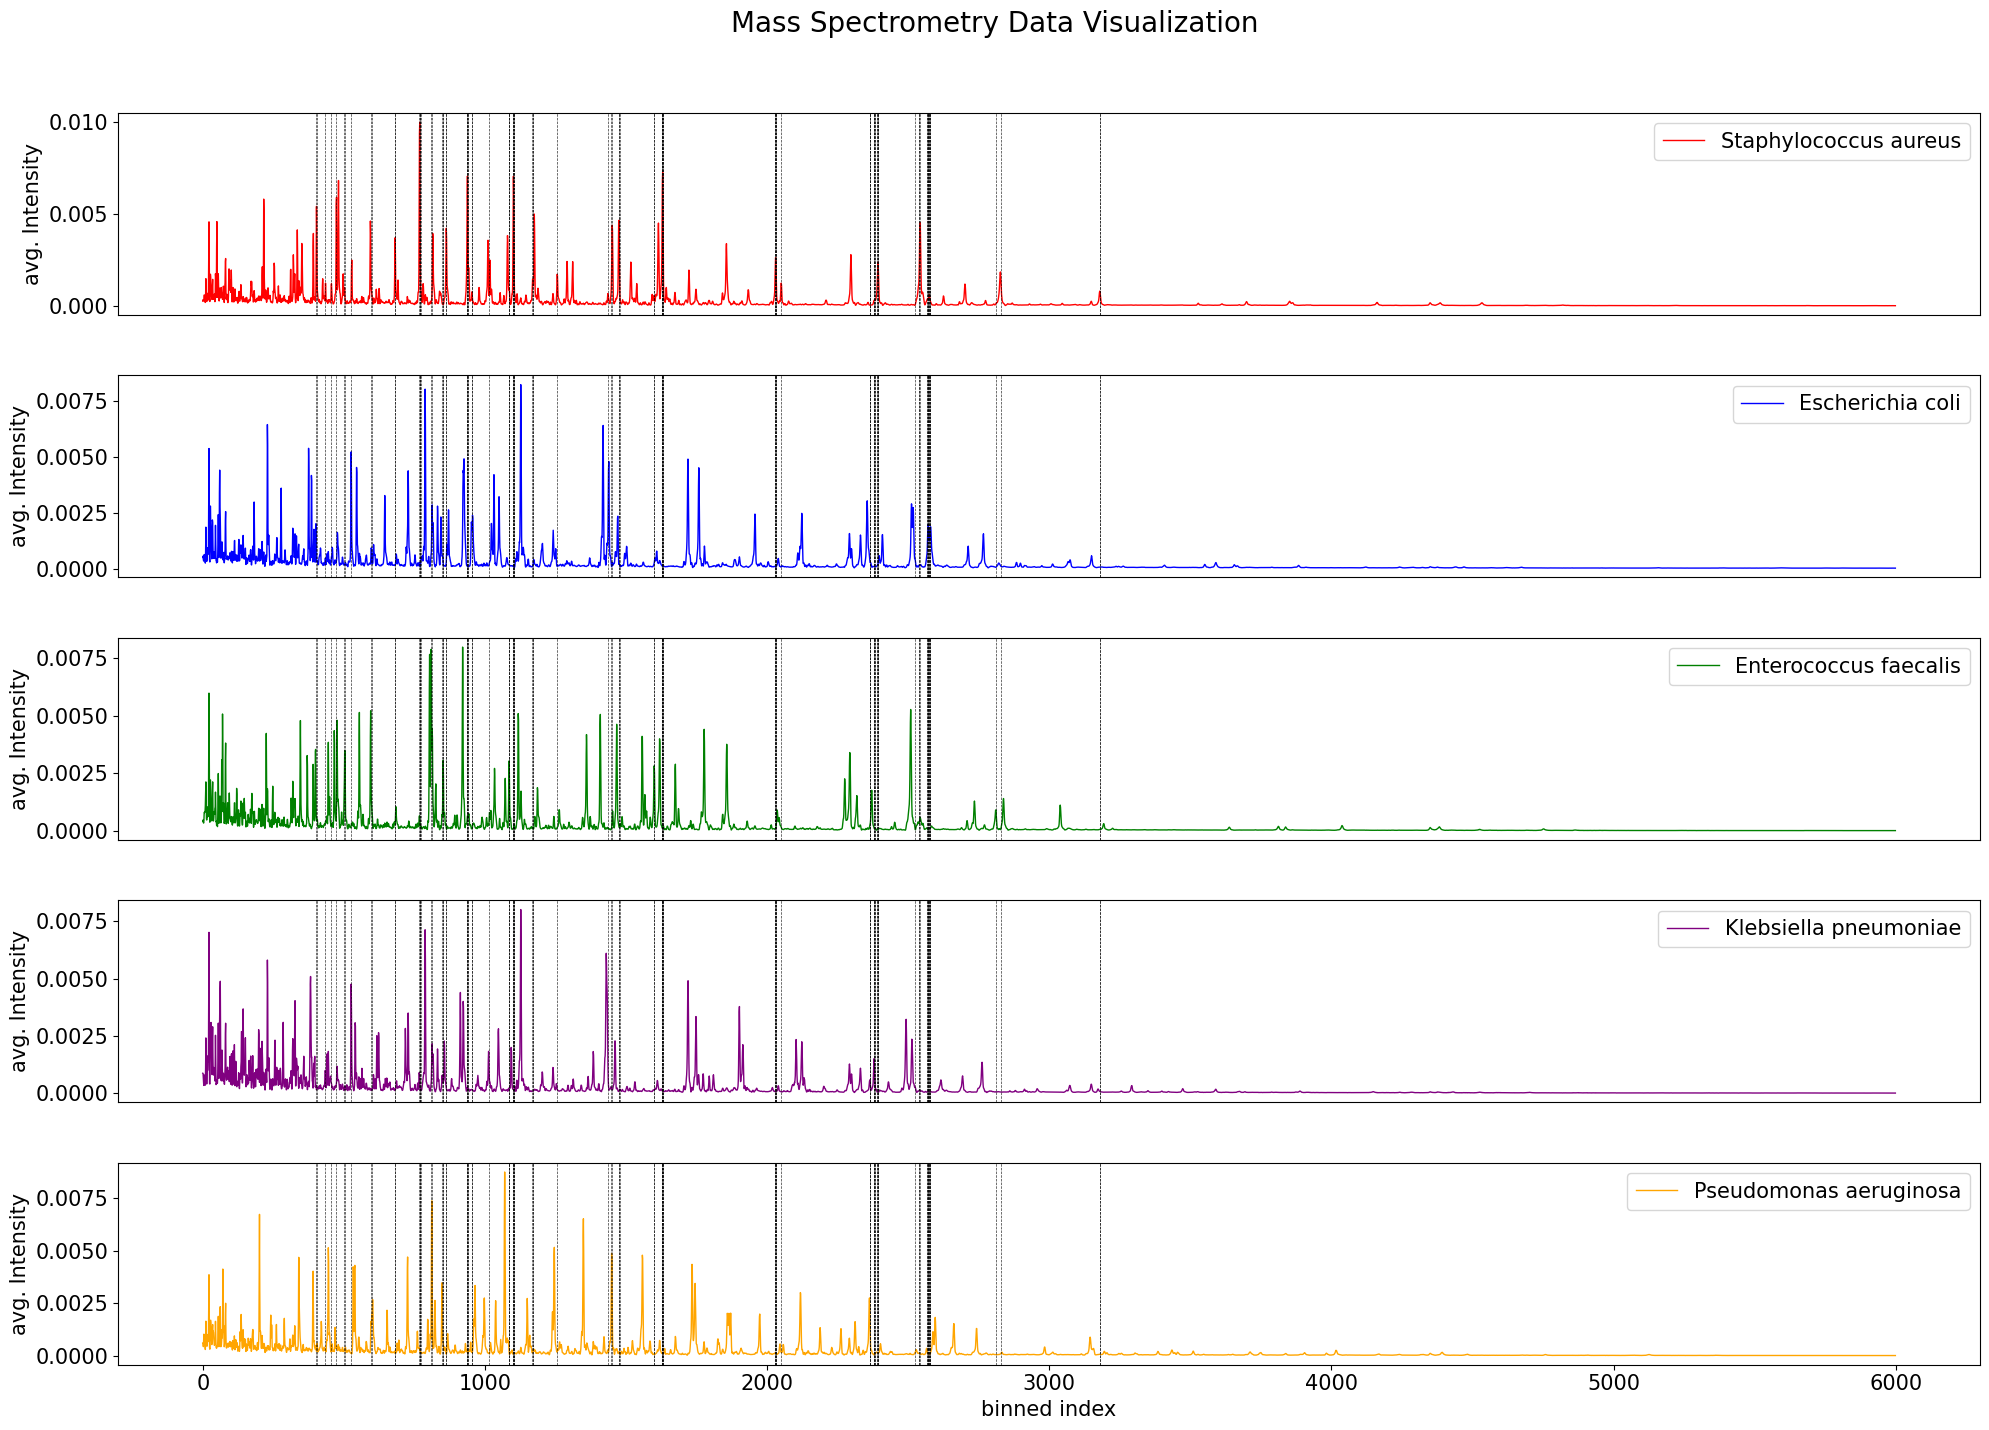

In [6]:
# 繪製平均光譜和特徵選擇的可視化
species_list = ['Staphylococcus aureus', 'Escherichia coli', 
                'Enterococcus faecalis', 'Klebsiella pneumoniae', 
                'Pseudomonas aeruginosa']

spectrum_columns = [col for col in df.columns if col.isdigit()]

# 計算每個物種的平均光譜
mean_spectra = {}
for species in species_list:
    species_data = df[df['species'] == species]
    mean_spectra[species] = species_data[spectrum_columns].mean()

mean_df = pd.DataFrame(mean_spectra).T

# 設置圖表
fig, axes = plt.subplots(5, 1, figsize=(20, 15))
fig.suptitle('Mass Spectrometry Data Visualization', fontsize=20)

species_colors = {
    'Staphylococcus aureus': 'red',
    'Escherichia coli': 'blue',
    'Enterococcus faecalis': 'green',
    'Klebsiella pneumoniae': 'purple',
    'Pseudomonas aeruginosa': 'orange'
}

# 對每個物種繪圖
for idx, (species, color) in enumerate(species_colors.items()):
    # 直接從mean_df取得該物種的平均光譜
    spectrum = mean_df.loc[species]
    
    # 繪製光譜
    axes[idx].plot(range(len(spectrum)), spectrum, color=color, linewidth=1)
    
    # 標記選中的特徵
    selected_indices = [int(col) for col in selected_indices]
    for selected_idx in selected_indices:
        axes[idx].axvline(x=selected_idx, color='black', alpha=0.8, linestyle='--', linewidth=0.5)
    
    # 設置標題和標籤
    if idx != 4:
        axes[idx].set_xticks([])
    else:
        axes[idx].set_xlabel('binned index', fontsize=15)
        axes[idx].tick_params(axis='x', labelsize=15)
    axes[idx].set_ylabel('avg. Intensity', fontsize=15)
    axes[idx].legend(loc='upper right', labels=[species], fontsize=15)
    axes[idx].tick_params(axis='y', labelsize=15)
    
    # 調整y軸的範圍使圖形更扁平
    current_ymin, current_ymax = axes[idx].get_ylim()
    range_y = current_ymax - current_ymin

# 調整子圖之間的間距
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.3)

plt.show()

In [5]:
# 準備特徵和標籤
feature_columns = final_selected_df.columns[~final_selected_df.columns.isin(['code', 'species', 'label'])]
X = final_selected_df[feature_columns]
y = final_selected_df['label']

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# 模型評估函數
def evaluate_model(model, X_test, y_test, model_name):
    # 獲取預測結果
    y_pred = model.predict(X_test)
    
    # 計算指標
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 打印評估結果
    print(f"======================= {model_name}模型評估 =======================")
    print(f"模型準確率: {accuracy:.4f}")
    print(f"精確率（Precision）: {precision:.4f}")
    print(f"召回率（Recall）: {recall:.4f}")
    print(f"F1 分數: {f1:.4f}")
    print("\n分類報告:")
    print(classification_report(y_test, y_pred))

    """# 繪製混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix of {model_name}')
    plt.show()"""

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# CNN評估的視覺化函數
def plot_cnn_history(history):
    plt.figure(figsize=(12, 4))
    
    # 繪製損失曲線
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 繪製準確率曲線
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Model 

In [16]:
# DecisionTree
dt_model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)

# 訓練模型
dt_model.fit(X_train, y_train)

# 預測測試集
dt_metrics = evaluate_model(dt_model, X_test, y_test, "DecisionTree")

======================= DecisionTree模型評估 =======================
模型準確率: 0.9981
精確率（Precision）: 0.9954
召回率（Recall）: 0.9977
F1 分數: 0.9966

分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00       437

    accuracy                           1.00      1612
   macro avg       1.00      1.00      1.00      1612
weighted avg       1.00      1.00      1.00      1612



In [17]:
# LinearSVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# 預測測試集
svm_metrics = evaluate_model(svm_model, X_test, y_test, "LinearSVM")

======================= LinearSVM模型評估 =======================
模型準確率: 0.9808
精確率（Precision）: 1.0000
召回率（Recall）: 0.9291
F1 分數: 0.9632

分類報告:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1175
           1       1.00      0.93      0.96       437

    accuracy                           0.98      1612
   macro avg       0.99      0.96      0.98      1612
weighted avg       0.98      0.98      0.98      1612



In [18]:
# XGBoost
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.005,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train_scaled, y_train)
xgb_metrics = evaluate_model(model_xgb, X_test_scaled, y_test, "XGBoost")

======================= XGBoost模型評估 =======================
模型準確率: 0.9975
精確率（Precision）: 1.0000
召回率（Recall）: 0.9908
F1 分數: 0.9954

分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      0.99      1.00       437

    accuracy                           1.00      1612
   macro avg       1.00      1.00      1.00      1612
weighted avg       1.00      1.00      1.00      1612



In [26]:
# LightGBM
d_train = lgb.Dataset(X_train_scaled, label=y_train)
d_test = lgb.Dataset(X_test_scaled, label=y_test, reference=d_train)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'scale_pos_weight': 4693/1754 # 處理類別不平衡
}

model_lgb = lgb.train(
    params,
    d_train,
    valid_sets=[d_train, d_test],
    valid_names=['train', 'eval']
)

y_pred_lgb = (model_lgb.predict(X_test_scaled) > 0.5).astype(int)
lgb_metrics = evaluate_model(
    type('LGBModel', (), {
        'predict': lambda x: (model_lgb.predict(x) > 0.5).astype(int)
    }),
    X_test_scaled, y_test, "LightGBM"
)

[LightGBM] [Info] Number of positive: 1754, number of negative: 4693
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 6447, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.272065 -> initscore=-0.984173
[LightGBM] [Info] Start training from score -0.984173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
======================= LightGBM模型評估 =======================
模型準確率: 0.9963
精確率（Precision）: 1.0000
召回率（Recall）: 0.9863
F1 分數: 0.9931

分類報告:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1175
           1       1.00      0.99 

In [20]:
# LogitBoost
model_logitboost = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)

model_logitboost.fit(X_train_scaled, y_train)
logitboost_metrics = evaluate_model(model_logitboost, X_test_scaled, y_test, "LogitBoost")

======================= LogitBoost模型評估 =======================
模型準確率: 0.9988
精確率（Precision）: 0.9977
召回率（Recall）: 0.9977
F1 分數: 0.9977

分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      1.00      1.00       437

    accuracy                           1.00      1612
   macro avg       1.00      1.00      1.00      1612
weighted avg       1.00      1.00      1.00      1612



In [21]:
# MLP
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50, 25),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)
mlp_metrics = evaluate_model(mlp_model, X_test_scaled, y_test, "MLP")

======================= MLP模型評估 =======================
模型準確率: 0.9981
精確率（Precision）: 1.0000
召回率（Recall）: 0.9931
F1 分數: 0.9966

分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      0.99      1.00       437

    accuracy                           1.00      1612
   macro avg       1.00      1.00      1.00      1612
weighted avg       1.00      1.00      1.00      1612



In [22]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_metrics = evaluate_model(knn_model, X_test_scaled, y_test, "KNN")

======================= KNN模型評估 =======================
模型準確率: 0.9981
精確率（Precision）: 1.0000
召回率（Recall）: 0.9931
F1 分數: 0.9966

分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      0.99      1.00       437

    accuracy                           1.00      1612
   macro avg       1.00      1.00      1.00      1612
weighted avg       1.00      1.00      1.00      1612



In [23]:
# 準備CNN的輸入數據
X_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

# 創建模型
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(AveragePooling1D(pool_size=2, input_shape=input_shape))
    
    # 第一個卷積單元
    model.add(Conv1D(16, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling1D(pool_size=2))
    
    # 第二個卷積單元
    model.add(Conv1D(32, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# 創建和訓練CNN模型
input_shape = (X_train_scaled.shape[1], 1)
cnn_model = create_cnn_model(input_shape)
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    X_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=10,
    batch_size=16,
    verbose=1
)

# 評估CNN
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn_binary = (y_pred_cnn > 0.5).astype(int)

# 使用相同的評估函數
cnn_metrics = evaluate_model(
    type('CNNModel', (), {
        'predict': lambda x: (cnn_model.predict(x) > 0.5).astype(int)
    }),
    X_test_cnn, y_test, "CNN"
)

Epoch 1/10


c:\Users\mingju\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\pooling\base_pooling.py:23: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(name=name, **kwargs)


403/403 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9841 - loss: 0.0512 - val_accuracy: 0.9975 - val_loss: 0.0068
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9981 - val_loss: 0.0062
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 4.2705e-04 - val_accuracy: 0.9988 - val_loss: 0.0071
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.4275e-04 - val_accuracy: 0.9994 - val_loss: 0.0025
Epoch 5/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 6.8980e-04 - val_accuracy: 0.9994 - val_loss: 0.0057
Epoch 6/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 2.6308e-04 - val_accuracy: 0.9994 - val_loss: 0.0074
Epoch 7/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 1.3500e-04 - val_accuracy: 0.9988 - val_loss: 0.0059
Epoch 8/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9996 - loss: 0.0012 - val_acc

In [28]:
# 模型比較
models_metrics = {
    'DecisionTree': dt_metrics,
    'LinearSVM': svm_metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgb_metrics,
    'LogitBoost': logitboost_metrics,
    'MLP': mlp_metrics,
    'KNN': knn_metrics,
    'CNN': cnn_metrics
}

# 創建比較表格
comparison_df = pd.DataFrame({
    'Model': models_metrics.keys(),
    'Accuracy': [m['accuracy'] for m in models_metrics.values()],
    'Precision': [m['precision'] for m in models_metrics.values()],
    'Recall': [m['recall'] for m in models_metrics.values()],
    'F1 Score': [m['f1'] for m in models_metrics.values()]
})

# 顯示結果
print("\nDRIAMS-A模型比較結果:")
print(comparison_df)

# 保存結果
comparison_df.to_csv("model_comparison_results.csv", index=False)


DRIAMS-A模型比較結果:
          Model  Accuracy  Precision    Recall  F1 Score
0  DecisionTree  0.998139   0.995434  0.997712  0.996571
1     LinearSVM  0.980769   1.000000  0.929062  0.963227
2       XGBoost  0.997519   1.000000  0.990847  0.995402
3      LightGBM  0.996278   1.000000  0.986270  0.993088
4    LogitBoost  0.998759   0.997712  0.997712  0.997712
5           MLP  0.998139   1.000000  0.993135  0.996556
6           KNN  0.998139   1.000000  0.993135  0.996556
7           CNN  0.998139   1.000000  0.993135  0.996556


# B,C,D資料集做驗證

In [31]:
def process_driams_dataset(base_folder, selected_indices, year="2018"):
    """處理每個DRIAMS數據集，使用與A相同的特徵索引"""
    # 讀取CSV文件
    csv_path = os.path.join(base_folder, "id", year, f"{year}_clean.csv")
    df = pd.read_csv(csv_path)
    
    bacteria_mapping = {
        'Escherichia coli': 0,
        'Enterococcus faecalis': 0,
        'Klebsiella pneumoniae': 0,  
        'Pseudomonas aeruginosa': 0,
        'Staphylococcus aureus': 1
    }
    
    # 篩選指定的細菌
    df_filtered = df[df['species'].isin(bacteria_mapping.keys())].copy()
    df_filtered['label'] = df_filtered['species'].map(bacteria_mapping)
    
    # 讀取光譜數據
    spectra_path = os.path.join(base_folder, "binned_6000", year)
    spectra_dict = {}
    
    for _, row in df_filtered.iterrows():
        code = row['code']
        spectrum_file = os.path.join(spectra_path, f"{code}.txt")
        
        if os.path.exists(spectrum_file):
            spectrum_data = pd.read_csv(spectrum_file, sep=' ')
            spectra_dict[code] = spectrum_data['binned_intensity'].values
    
    # 合併數據
    spectra_df = pd.DataFrame.from_dict(spectra_dict, orient='index')
    # 確保列名為數字字符串
    spectra_df.columns = [str(i) for i in range(spectra_df.shape[1])]
    
    final_df = pd.merge(df_filtered, spectra_df, left_on='code', right_index=True)
    
    # 只選擇與A相同的特徵
    spectrum_cols = [str(idx) for idx in selected_indices]
    metadata_cols = ['code', 'species', 'label']
    
    return final_df[metadata_cols + spectrum_cols]

# 處理每個DRIAMS數據集
driams_folders = {
    'B': "./DRIAMS-B",
    'C': "./DRIAMS-C",
    'D': "./DRIAMS-D"
}

# 存儲所有數據集的結果
results = {}

for dataset_name, folder_path in driams_folders.items():
    print(f"\nProcessing DRIAMS-{dataset_name}...")
    try:
        # 處理數據集，傳入選定的特徵索引
        dataset = process_driams_dataset(folder_path, selected_indices)
        
        # 準備特徵
        X_test = dataset[feature_columns]
        y_test = dataset['label']
        
        # 標準化
        X_test_scaled = scaler.transform(X_test)
        
        # 評估每個模型
        print(f"\nEvaluating DRIAMS-{dataset_name}:")
        results[dataset_name] = {
            'DecisionTree': evaluate_model(dt_model, X_test, y_test, f"DecisionTree-DRIAMS-{dataset_name}"),
            'LinearSVM': evaluate_model(svm_model, X_test, y_test, f"LinearSVM-DRIAMS-{dataset_name}"),
            'XGBoost': evaluate_model(model_xgb, X_test_scaled, y_test, f"XGBoost-DRIAMS-{dataset_name}"),
            'LightGBM': evaluate_model(
                type('LGBModel', (), {'predict': lambda x: (model_lgb.predict(x) > 0.5).astype(int)}),
                X_test_scaled, y_test, f"LightGBM-DRIAMS-{dataset_name}"),
            'LogitBoost': evaluate_model(model_logitboost, X_test_scaled, y_test, f"LogitBoost-DRIAMS-{dataset_name}"),
            'MLP': evaluate_model(mlp_model, X_test_scaled, y_test, f"MLP-DRIAMS-{dataset_name}"),
            'KNN': evaluate_model(knn_model, X_test_scaled, y_test, f"KNN-DRIAMS-{dataset_name}")
        }
        
    except Exception as e:
        print(f"Error processing DRIAMS-{dataset_name}: {str(e)}")

# 創建比較表格
comparison_results = []
for dataset in results:
    for model in results[dataset]:
        metrics = results[dataset][model]
        comparison_results.append({
            'Dataset': f'DRIAMS-{dataset}',
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1']
        })

comparison_df = pd.DataFrame(comparison_results)
print("\n所有數據集的模型比較結果:")
print(comparison_df)

# 保存結果
comparison_df.to_csv("all_datasets_comparison.csv", index=False)


Processing DRIAMS-B...

Evaluating DRIAMS-B:
======================= DecisionTree-DRIAMS-B模型評估 =======================
模型準確率: 0.9981
精確率（Precision）: 0.9972
召回率（Recall）: 0.9972
F1 分數: 0.9972

分類報告:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       679
           1       1.00      1.00      1.00       353

    accuracy                           1.00      1032
   macro avg       1.00      1.00      1.00      1032
weighted avg       1.00      1.00      1.00      1032

======================= LinearSVM-DRIAMS-B模型評估 =======================
模型準確率: 0.9390
精確率（Precision）: 1.0000
召回率（Recall）: 0.8215
F1 分數: 0.9020

分類報告:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       679
           1       1.00      0.82      0.90       353

    accuracy                           0.94      1032
   macro avg       0.96      0.91      0.93      1032
weighted avg       0.94      0.94      0.94      1032
